# ML Final Project - Data Procuration / Cleaning
### Lauren Blanks, Tom Kyle, Brenton Pieper

Much of this notebook is inspired by the work from our "seminal" kaggle data page. The mentioned notebook is referenced/ cited in our report, as well.

### Load Packages / Data

In [17]:
# load packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from scipy.signal import savgol_filter
import statsmodels.api as sm
import pymc3 as pm
import statsmodels.api as sm
from statsmodels.tools import add_constant
from itertools import combinations
# settings for seaborn plotting style
sns.set(color_codes=True)
# settings for seaborn plot sizes
sns.set(rc={'figure.figsize':(12,6)})

In [18]:
# read the data
data = pd.read_csv('nfl_team_stats_2002-2021.csv')
data.head()

,date,away,home,first_downs_away,first_downs_home,third_downs_away,third_downs_home,fourth_downs_away,fourth_downs_home,passing_yards_away,...,redzone_away,redzone_home,drives_away,drives_home,def_st_td_away,def_st_td_home,possession_away,possession_home,score_away,score_home
0,2002-09-05,49ers,Giants,13,21,4-12,9-16,0-0,0-1,166,...,0-8,0-6,13,15,0,0,27:32,32:28,16,13
1,2002-09-08,Jets,Bills,18,26,2-8,7-17,0-0,2-2,193,...,0-9,0-8,17,18,2,0,21:06,39:08,37,31
2,2002-09-08,Vikings,Bears,19,20,5-13,7-13,0-0,0-0,228,...,0-7,0-6,17,17,0,0,31:31,28:29,23,27
3,2002-09-08,Chargers,Bengals,27,13,6-10,4-11,0-0,0-0,160,...,0-7,0-5,11,15,0,0,37:48,22:12,34,6
4,2002-09-08,Chiefs,Browns,24,24,5-11,4-11,0-0,0-0,276,...,0-10,0-10,20,17,0,0,30:16,29:44,40,39


### Clean Data and Add Necessary Features

In [4]:
# create a new column for score differential and 'winner' = 1 if home teawm wins - DEPENDENT VARIABLE
data['score_diff'] = data['score_home'] - data['score_away']
data['winner'] = (data['score_home'] - data['score_away'])>0
data['winner'] = data['winner'].astype(int)

In [5]:
# 56.37 % should be a lower bound benchmark for the model
np.mean(data.winner)

0.5637483666231099

In [6]:
# split string info for third down attmepts to float succeses and rate
third_downs_away = data['third_downs_away'].str.split('-', expand=True)
data['third_downs_away'] = third_downs_away[0].to_numpy(dtype=int)
data['third_downs_rate_away'] = np.nan_to_num(third_downs_away[0].to_numpy(dtype=float)/third_downs_away[1].to_numpy(dtype=float), nan=0.0)
data['third_downs_attempts_away'] = third_downs_away[1].to_numpy(dtype=int)

third_downs_home = data['third_downs_home'].str.split('-', expand=True)
data['third_downs_home'] = third_downs_home[0].to_numpy(dtype=int)
data['third_downs_rate_home'] = np.nan_to_num(third_downs_home[0].to_numpy(dtype=float)/third_downs_home[1].to_numpy(dtype=float), nan=0.0)
data['third_downs_attempts_home'] = third_downs_home[1].to_numpy(dtype=int)

In [7]:
# split string info for fourth down attmepts to float succeses and rate
fourth_downs_away = data['fourth_downs_away'].str.split('-', expand=True)
data['fourth_downs_away'] = fourth_downs_away[0].to_numpy(dtype=int)
data['fourth_downs_rate_away'] = np.nan_to_num(fourth_downs_away[0].to_numpy(dtype=float)/fourth_downs_away[1].to_numpy(dtype=float), nan=0.0)
data['fourth_downs_attempts_away'] = fourth_downs_away[1].to_numpy(dtype=int)

fourth_downs_home = data['fourth_downs_home'].str.split('-', expand=True)
data['fourth_downs_home'] = third_downs_home[0].to_numpy(dtype=int)
data['fourth_downs_rate_home'] = np.nan_to_num(third_downs_home[0].to_numpy(dtype=float)/third_downs_home[1].to_numpy(dtype=float), nan=0.0)
data['fourth_downs_attempts_home'] = third_downs_home[1].to_numpy(dtype=int)

/var/folders/6k/39pgnfs54wn25kbnd913q5wr0000gn/T/ipykernel_28372/3369208164.py:4: RuntimeWarning: invalid value encountered in true_divide
  data['fourth_downs_rate_away'] = np.nan_to_num(fourth_downs_away[0].to_numpy(dtype=float)/fourth_downs_away[1].to_numpy(dtype=float), nan=0.0)


In [8]:
# split string info for completions to float succeses and rate
comp_att_away = data['comp_att_away'].str.split('-', expand=True)
data['complete_passes_away'] = comp_att_away[0].to_numpy(dtype=int)
data['pass_completion_rate_away'] = np.nan_to_num(comp_att_away[0].to_numpy(dtype=float)/comp_att_away[1].to_numpy(dtype=float), nan=0.0)
data['pass_attempt_away'] = comp_att_away[1].to_numpy(dtype=int)
data.drop('comp_att_away',1, inplace=True)

comp_att_home = data['comp_att_home'].str.split('-', expand=True)
data['complete_passes_home'] = comp_att_home[0].to_numpy(dtype=int)
data['pass_completion_rate_home'] = np.nan_to_num(comp_att_home[0].to_numpy(dtype=float)/comp_att_home[1].to_numpy(dtype=float), nan=0.0)
data['pass_attempt_home'] = comp_att_home[1].to_numpy(dtype=int)
data.drop('comp_att_home',1, inplace=True)

/var/folders/6k/39pgnfs54wn25kbnd913q5wr0000gn/T/ipykernel_28372/759447164.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data.drop('comp_att_away',1, inplace=True)
/var/folders/6k/39pgnfs54wn25kbnd913q5wr0000gn/T/ipykernel_28372/759447164.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data.drop('comp_att_home',1, inplace=True)


In [9]:
# split string info for sacks to float succeses and rate
sacks_away = data['sacks_away'].str.split('-', expand=True)
data['sacks_away'] = sacks_away[0].to_numpy(dtype=int)
data['pressures_away'] = sacks_away[1].to_numpy(dtype=int)

sacks_home = data['sacks_home'].str.split('-', expand=True)
data['sacks_home'] = sacks_home[0].to_numpy(dtype=int)
data['pressures_home'] = sacks_home[1].to_numpy(dtype=int)

In [10]:
# split string info for penalties to float succeses and rate
penalties_away = data['penalties_away'].str.split('-', expand=True)
data['penalties_away'] = np.nan_to_num(penalties_away[0].to_numpy(dtype=int), nan=0.0)
data['penalties_yards_away'] = np.nan_to_num(penalties_away[1].to_numpy(dtype=int), nan=0.0)

penalties_home = data['penalties_home'].str.split('-', expand=True)
data['penalties_home'] = np.nan_to_num(penalties_home[0].to_numpy(dtype=int), nan=0.0)
data['penalties_yards_home'] = np.nan_to_num(penalties_home[1].to_numpy(dtype=int), nan=0.0)

In [11]:
# split string info for redzone attempts to float succeses and rate
redzone_away = data['redzone_away'].str.split('-', expand=True)
data['redzone_sucess_away'] = redzone_away[0].to_numpy(dtype=int)
data['redzone_rate_away'] = np.nan_to_num(redzone_away[0].to_numpy(dtype=float)/redzone_away[1].to_numpy(dtype=float), nan=0.0)
data['redzone_attempts_away'] = redzone_away[1].to_numpy(dtype=int)
data.drop('redzone_away',1, inplace=True)

redzone_home = data['redzone_home'].str.split('-', expand=True)
data['redzone_sucess_home'] = redzone_home[0].to_numpy(dtype=int)
data['redzone_rate_home'] = np.nan_to_num(redzone_home[0].to_numpy(dtype=float)/redzone_home[1].to_numpy(dtype=float), nan=0.0)
data['redzone_attempts_home'] = redzone_home[1].to_numpy(dtype=int)
data.drop('redzone_home',1, inplace=True)

/var/folders/6k/39pgnfs54wn25kbnd913q5wr0000gn/T/ipykernel_28372/181541541.py:4: RuntimeWarning: invalid value encountered in true_divide
  data['redzone_rate_away'] = np.nan_to_num(redzone_away[0].to_numpy(dtype=float)/redzone_away[1].to_numpy(dtype=float), nan=0.0)
/var/folders/6k/39pgnfs54wn25kbnd913q5wr0000gn/T/ipykernel_28372/181541541.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data.drop('redzone_away',1, inplace=True)
/var/folders/6k/39pgnfs54wn25kbnd913q5wr0000gn/T/ipykernel_28372/181541541.py:10: RuntimeWarning: invalid value encountered in true_divide
  data['redzone_rate_home'] = np.nan_to_num(redzone_home[0].to_numpy(dtype=float)/redzone_home[1].to_numpy(dtype=float), nan=0.0)
/var/folders/6k/39pgnfs54wn25kbnd913q5wr0000gn/T/ipykernel_28372/181541541.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keywor

In [12]:
# split string info for possessions to float succeses and rate
possession_away = data['possession_away'].str.split(':', expand=True)
data['possession_away'] = possession_away[0].to_numpy(dtype=float) * 60 + possession_away[1].to_numpy(dtype=float)

possession_home = data['possession_home'].str.split(':', expand=True)
data['possession_home'] = possession_home[0].to_numpy(dtype=float) * 60 + possession_home[1].to_numpy(dtype=float)

In [13]:
# create a column for the season of the game
day_numbers = pd.to_numeric((pd.to_datetime(data['date']) - pd.to_datetime(data['date'][0])).dt.days,
                            downcast='integer')
years = np.ones(len(day_numbers))*2002
for idx in range(1,len(day_numbers)):
    years[idx] = years[idx-1] + ((day_numbers[idx]-day_numbers[idx-1]) > 30)*1
data['season'] = years

### Examine Current Features

In [14]:
# Let's see what kind of raw features we are rocking with here
column_names = list(data.columns)
len(column_names)

62

In [147]:
# display the head
data.head()

,date,away,home,first_downs_away,first_downs_home,third_downs_away,third_downs_home,fourth_downs_away,fourth_downs_home,passing_yards_away,...,pressures_home,penalties_yards_away,penalties_yards_home,redzone_sucess_away,redzone_rate_away,redzone_attempts_away,redzone_sucess_home,redzone_rate_home,redzone_attempts_home,season
0,2002-09-05,49ers,Giants,13,21,4,9,0,9,166,...,24,29,80,0,0.0,8,0,0.0,6,2002.0
1,2002-09-08,Jets,Bills,18,26,2,7,0,7,193,...,29,90,82,0,0.0,9,0,0.0,8,2002.0
2,2002-09-08,Vikings,Bears,19,20,5,7,0,7,228,...,9,52,33,0,0.0,7,0,0.0,6,2002.0
3,2002-09-08,Chargers,Bengals,27,13,6,4,0,4,160,...,31,39,57,0,0.0,7,0,0.0,5,2002.0
4,2002-09-08,Chiefs,Browns,24,24,5,4,0,4,276,...,7,87,38,0,0.0,10,0,0.0,10,2002.0


In [148]:
# check that there are no NaNs
data.columns[data.isna().any()].tolist()
# Yay :)

[]

### Some Initial Exploratory Analysis

<AxesSubplot:xlabel='total_yards_home', ylabel='score_home'>

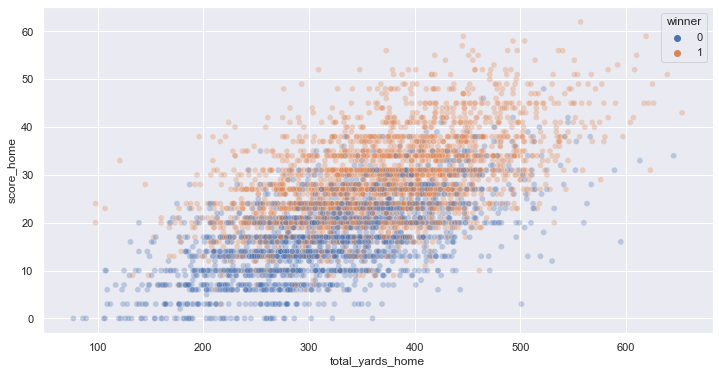

In [149]:
# create a seaborn scatter plot on total_yards_home and score_home - should be some good correlation here
sns.scatterplot(x='total_yards_home', y='score_home', data=data, alpha=0.3, hue=data.winner)

<AxesSubplot:xlabel='total_yards_home', ylabel='score_home'>

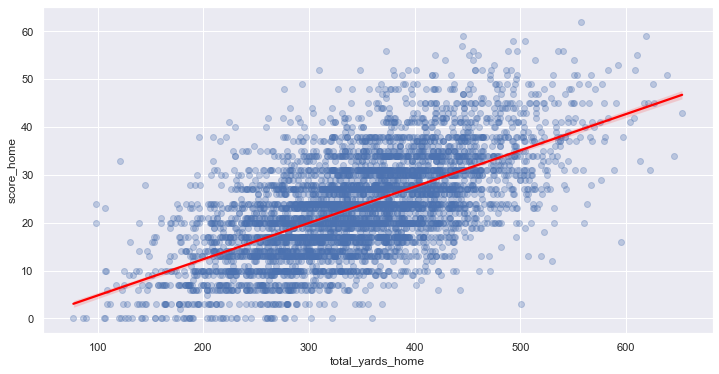

In [150]:
# Let's do a regression plot on total_yards_home and score_home
sns.regplot(x='total_yards_home', y='score_home', data=data, scatter_kws={'alpha':0.3}, line_kws={'color':'red'})

### Build Dataframes for Each Team

In [151]:
# create home and away dataframe
df_home = data
df_away = data

# create a column 'team' with team name and 'opponent' with the oponent temas name
df_home = df_home.rename({'home': 'team', 'away': 'opponent'}, axis=1)
df_away = df_away.rename({'away': 'team', 'home': 'opponent'}, axis=1)
# create a column 'home' determining if the game was home game
df_home['home'] = 'Y'
df_away['home'] = 'N'

# rename the columns to reflect team and opponent instead of home and away
for name in column_names[3:]:
    if 'home' in name:
        df_home = df_home.rename({name: name.replace('_home','')}, axis=1)
        df_away = df_away.rename({name: name.replace('_home','_opp')}, axis=1)
    else:
        df_home = df_home.rename({name: name.replace('_away','_opp')}, axis=1)
        df_away = df_away.rename({name: name.replace('_away','')}, axis=1)
        
df_away['winner'] = 1-df_away['winner']
df_away['score_diff'] = -df_away['score_diff']

df = pd.concat([df_home,df_away])
df['day_number'] = pd.to_numeric((pd.to_datetime(df['date']) - pd.to_datetime(data['date'][0])).dt.days, downcast='integer')
df.sort_values(by=['day_number'], inplace=True)

At this point, the dataframe is structured as follows. Each game has a date, team, and opponent. The team is the 'main character' in each row of data. So, all features in a given row reference the "team" column unless otherwise there is an _opp at the end of the feature. The "home" column indicates whether or not the team listed in the "team" column was home or not (Y/N). Each game has two rows of data associated with it. Essentially, the two rows are the same, except the team/opponent columns are swapped, and the rest of the features are swapped accordingly. This structure allows us to easy generate features (weighted averages) for each team by filtering the "team" column.

In [152]:
# create a dataframe for each team
team_names = np.unique(data.away)
team_results = {}
team_results_avg = {}     
for name in team_names:
    team_results[name] = df.loc[df['team'] == name].sort_values(by=['day_number'], inplace=False)
    team_results_avg[name] = df.loc[df['team'] == name].sort_values(by=['day_number'], inplace=False)

In [153]:
# check results of the best team in the NFL - lol
np.mean(team_results['Steelers'].winner)
team_results['Steelers']


,date,opponent,team,first_downs_opp,first_downs,third_downs_opp,third_downs,fourth_downs_opp,fourth_downs,passing_yards_opp,...,penalties_yards,redzone_sucess_opp,redzone_rate_opp,redzone_attempts_opp,redzone_sucess,redzone_rate,redzone_attempts,season,home,day_number
15,2002-09-09,Patriots,Steelers,20,20,5,4,5,2,280,...,112,0,0.000000,4,0,0.000000,8,2002.0,N,4
30,2002-09-15,Raiders,Steelers,27,14,12,4,0,4,369,...,57,0,0.000000,5,0,0.000000,4,2002.0,Y,10
52,2002-09-29,Browns,Steelers,13,21,5,5,0,5,122,...,45,0,0.000000,4,0,0.000000,9,2002.0,Y,24
66,2002-10-06,Saints,Steelers,17,23,5,7,5,1,194,...,80,0,0.000000,6,0,0.000000,7,2002.0,N,31
74,2002-10-13,Bengals,Steelers,18,21,8,7,8,0,190,...,50,0,0.000000,6,0,0.000000,5,2002.0,N,38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5286,2021-12-19,Titans,Steelers,22,12,8,2,1,2,117,...,30,1,0.250000,4,1,0.333333,3,2021.0,Y,7045
5308,2021-12-26,Chiefs,Steelers,25,20,4,5,4,2,254,...,40,4,0.666667,6,1,0.250000,4,2021.0,N,7052
5327,2022-01-03,Browns,Steelers,15,20,5,5,1,5,139,...,51,2,1.000000,2,1,0.333333,3,2021.0,Y,7060
5335,2022-01-09,Ravens,Steelers,20,19,3,6,3,1,132,...,43,0,0.000000,2,1,0.333333,3,2021.0,N,7066


# Feature Engineering Optimization
This section determines the optimal set of parameters for generating the weighted averages of the parameters in the data. These weighted averages will be the features in our team's Machine Learning Models.

In [154]:
# TEST TEST TEST TEST TEST

N = 20

column_indices_to_avg = np.where([x in team_results['Bills'].select_dtypes(['number']).columns for x in team_results['Bills'].columns])


def test_weights(N, n1, n2, normalize=False):
    for name in team_names:
        for idx in range(N,team_results[name].shape[0]):
            # Determine the days to the previous games, then weights for then weighted average.
            # Weights drop by about 7% for each previous week, or
            # by 90% going back to a previous season
            days = team_results[name].iloc[(idx-N):(idx-1)]['day_number'].to_numpy(dtype=float)
            days = days-days[-1]
            # 200 and 400 are chosen to give a 7% drop for each week - can be changes
            coeff = np.exp(days/n1)/np.sum(np.exp(days/n2))
            for col_idx in column_indices_to_avg:
                team_results_avg[name].iloc[idx,col_idx] = np.dot(coeff,team_results[name].iloc[(idx-N):(idx-1),col_idx])
            
    data_home = pd.DataFrame(columns = team_results_avg['Bills'].columns) 
    data_away = pd.DataFrame(columns = team_results_avg['Bills'].columns) 

    for idx in range(data.shape[0]):
        # get the date for this row
        date = data.iloc[idx].date
        # get the home and away team for this row
        home_team = data.iloc[idx].home
        away_team = data.iloc[idx].away
        home_data = team_results_avg[home_team].loc[team_results_avg[home_team]['date'] == date]
        away_data = team_results_avg[away_team].loc[team_results_avg[away_team]['date'] == date]
        # concatonate the rows to each data_home, data_away
        data_home = pd.concat([data_home,home_data])
        data_away = pd.concat([data_away,away_data])
        
    # append '_homeAvg' and '_awayAvg' to the home and away datframes
    for name in data_home.columns:
        data_home = data_home.rename({name: name+'_homeAvg'}, axis=1)
        data_away = data_away.rename({name: name+'_awayAvg'}, axis=1)

    # drop un-needed columns the home and away datframes
    data_home = data_home.drop(['date_homeAvg', 'team_homeAvg', 'opponent_homeAvg'], axis=1)
    data_away = data_away.drop(['date_awayAvg', 'team_awayAvg', 'opponent_awayAvg'], axis=1)

    df = pd.concat([data[['date','home','away','winner','score_home','score_away','score_diff']],data_home,data_away], axis=1, sort=False)

    # generate a logistic regression model on df using all columns with avg in the name as x and winner as y
    # then return the accuracy of the model
    x = df.loc[:, df.columns.str.contains('Avg')]
    # remove 'home_homeAvg' and 'home_awayAvg' from x
    features = x.columns.tolist()
    features.remove('home_homeAvg')
    features.remove('home_awayAvg')
    x = x[features]
    if normalize:
        x = (x - x.mean()) / x.std()
    y = df['winner']

    # split the data into training and testing sets
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

    # train the model
    #model = LogisticRegression(solver='lbfgs', max_iter=10000000, penalty='l2')
    model = LogisticRegression(solver='sag', max_iter=10000000, penalty='l2')
    model.fit(x_train, y_train)

    # test the model
    y_pred = model.predict(x_test)
    return accuracy_score(y_test, y_pred)




In [161]:
# test test_weights with n1 = 200 and n2 = 400
baseline = test_weights(20, 200,400,normalize=False)

Previous 16 games is king.

In [167]:
# for every other N 2-20, test test_weights with n1 = 200 and n2 = 400 and plot the results
N_list = [10,15,16,18]
acc = []
for N in N_list:
    acc.append(test_weights(N, 200,400,normalize=False))


<function matplotlib.pyplot.show(close=None, block=None)>

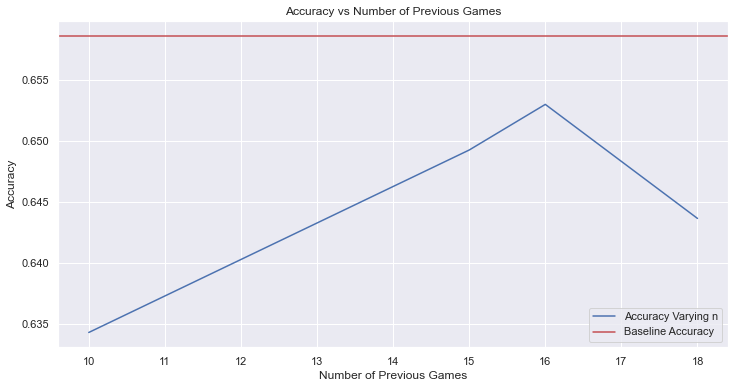

In [168]:
# plot N_list vs acc
plt.plot(N_list,acc)

# add labels to the plot
plt.xlabel('Number of Previous Games')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Number of Previous Games')

# plot the baseline
plt.axhline(y=baseline, color='r', linestyle='-')

# add a legend
plt.legend(['Accuracy Varying n','Baseline Accuracy'])

# save the plot
plt.savefig('Accuracy_vs_Number_of_Previous_Games.jpg')
plt.show

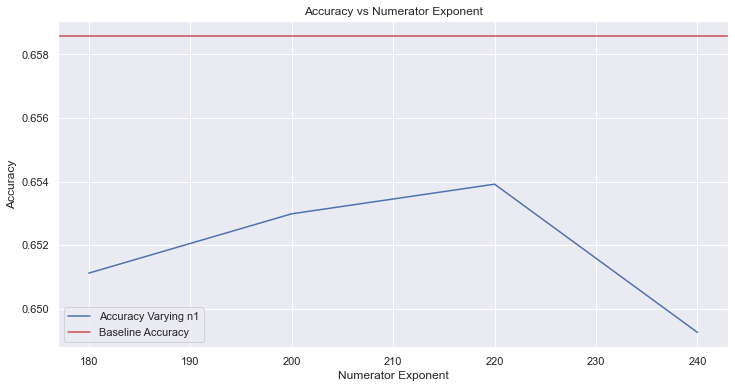

In [169]:
# for n1 in [100,200,300], test test_weights with n2 = 400 and plot the results
n1_list = [180,200,220,240]
acc = []
for n1 in n1_list:
    acc.append(test_weights(16, n1,400,normalize=False))

# plot n1_list vs acc
plt.plot(n1_list,acc)

# plot the baseline
plt.axhline(y=baseline, color='r', linestyle='-')

# add a legend
plt.legend(['Accuracy Varying n1','Baseline Accuracy'])

# add labels to the plot
plt.xlabel('Numerator Exponent')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Numerator Exponent')

# save the plot
plt.savefig('Accuracy_vs_Numerator_Exponent.jpg')

n1 = 220 takes the cake. So far, we have N=16, n1=220, and now we will test n2.

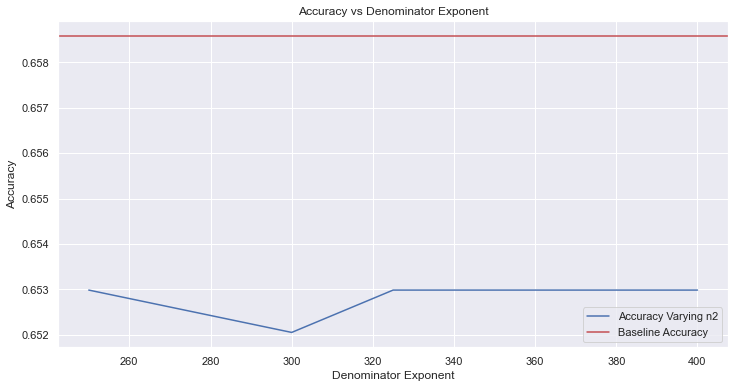

In [170]:
# for n2 in [300,400,500], test test_weights with n1 = 200 and plot the results
n2_list = [250,300,325, 350,400]
acc = []
for n2 in n2_list:
    acc.append(test_weights(16, 200,n2,normalize=False))

# plot n2_list vs acc
plt.plot(n2_list,acc)

# plot the baseline
plt.axhline(y=baseline, color='r', linestyle='-')

# add a legend
plt.legend(['Accuracy Varying n2','Baseline Accuracy'])

# add labels to the plot
plt.xlabel('Denominator Exponent')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Denominator Exponent')

# save the plot
plt.savefig('Accuracy_vs_Denominator_Exponent.jpg')

n2=350 is the maximum. So, the optimal parameters of the feature engineering are n=16, n1=220, and n2=350. However, using these parameters to generate the weighted averages as features yields models that perform worse than our baseline (n=20, n1=200,n2=400). So, we will assume that this setting is optimal for our models moving forward. This corresponds to about a 7% drop in importance for week $w-1$ compared to week $w$, and considers a team's previous 20 games (about 1 season).

In [173]:
def feature_engineering(N, n1, n2, normalize=False):
    for name in team_names:
        for idx in range(N,team_results[name].shape[0]):
            # Determine the days to the previous games, then weights for then weighted average.
            # Weights drop by about 7% for each previous week, or
            # by 90% going back to a previous season
            days = team_results[name].iloc[(idx-N):(idx-1)]['day_number'].to_numpy(dtype=float)
            days = days-days[-1]
            # 200 and 400 are chosen to give a 7% drop for each week - can be changes
            coeff = np.exp(days/n1)/np.sum(np.exp(days/n2))
            for col_idx in column_indices_to_avg:
                team_results_avg[name].iloc[idx,col_idx] = np.dot(coeff,team_results[name].iloc[(idx-N):(idx-1),col_idx])
            
    data_home = pd.DataFrame(columns = team_results_avg['Bills'].columns) 
    data_away = pd.DataFrame(columns = team_results_avg['Bills'].columns) 

    for idx in range(data.shape[0]):
        # get the date for this row
        date = data.iloc[idx].date
        # get the home and away team for this row
        home_team = data.iloc[idx].home
        away_team = data.iloc[idx].away
        home_data = team_results_avg[home_team].loc[team_results_avg[home_team]['date'] == date]
        away_data = team_results_avg[away_team].loc[team_results_avg[away_team]['date'] == date]
        # concatonate the rows to each data_home, data_away
        data_home = pd.concat([data_home,home_data])
        data_away = pd.concat([data_away,away_data])
        
    # append '_homeAvg' and '_awayAvg' to the home and away datframes
    for name in data_home.columns:
        data_home = data_home.rename({name: name+'_homeAvg'}, axis=1)
        data_away = data_away.rename({name: name+'_awayAvg'}, axis=1)

    # drop un-needed columns the home and away datframes
    data_home = data_home.drop(['date_homeAvg', 'team_homeAvg', 'opponent_homeAvg'], axis=1)
    data_away = data_away.drop(['date_awayAvg', 'team_awayAvg', 'opponent_awayAvg'], axis=1)

    df = pd.concat([data[['date','home','away','winner','score_home','score_away','score_diff']],data_home,data_away], axis=1, sort=False)

    return df

df = feature_engineering(20,200,400,normalize=False)


In [174]:
df.shape

(5357, 129)

### Save df (w/ averages) and data (w/out averages)

In [175]:
# save df  and data as a pickle file
df.to_pickle('/Users/thomaskyle/Desktop/Machine Learning/Final Project/nfl_df_averages.pkl')